# Wasserstein GAN

<img src="https://miro.medium.com/max/3200/1*M_YipQF_oC6owsU1VVrfhg.jpeg"  width="800" height="400">

##### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from time import time
import pandas as pd
import argparse
import math
import sys
import re
import itertools
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
import os
os.chdir('C:/Users/Nicolas/Documents/Data/Faces')

##### Function to sort files

In [3]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

##### Loading the 800 women

In [4]:
def load_women():
    faces = pd.read_csv('800_women.csv', header=None).values
    faces = faces.ravel().tolist()
    return faces
faces = load_women()
y = np.repeat(1, len(faces))

##### Removing problematic target names

In [5]:
# faces = [i for i in files if (i[-34] == '1') and len(i[-37:-35].strip('\\').strip('d'))  == 2 ] # MEN

In [6]:
# y = [i[-34] for i in files if (i[-34] == '1') and len(i[-37:-35].strip('\\').strip('d')) > 1 ] # MEN

In [7]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### This is the shape width/height

In [8]:
dim = 60

#### Cropping function

In [9]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [10]:
print('Scaling...', end='')
start = time()
x = []
num_to_load = len(faces) # int(len(faces)/5) 
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')

Done. 1 seconds


##### Turning the pictures into arrays

In [11]:
x = np.array(x, dtype=np.float32).reshape(-1, 1, 60, 60)
y = np.array(y, dtype=np.float32)
labels = y.copy()

##### Turning the targets into a 2D matrix

In [12]:
assert x.ndim == 4, 'The input is the wrong shape!'

In [13]:
yy, xx = y.nbytes, x.nbytes

In [14]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 11,520,000 bytes and the size of Y is 3,200 bytes.


In [15]:
files, faces = None, None

##### Displaying the pictures

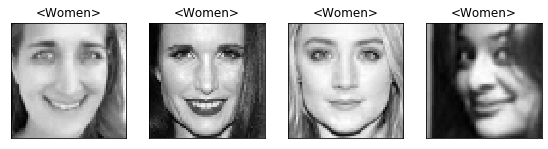

In [16]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(0, x.shape[0])
    ax = plt.imshow(x[rand][0, :, :], cmap='gray')
    plt.title('<Women>')
    yticks = plt.xticks([])
    yticks = plt.yticks([])

In [17]:
print('Scaling...', end='')
image_size = x.shape[1] * x.shape[1] 
x = (x.astype('float32') - 127.5) / 127.5
print('\rDone.     ')

Done.     


In [18]:
if torch.cuda.is_available():
    x = torch.from_numpy(x) 
    y = torch.from_numpy(y)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Making a dataset class

In [19]:
class Face():
    
    def __init__(self):
        self.len = x.shape[0]
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return x[index], y[index].unsqueeze(0)
    
    def __len__(self):
        return self.len

##### Instantiating the class

In [20]:
faces = Face()

##### Parsing the args

In [30]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1_000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00005, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=32, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=60, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.005, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=1, help="interval betwen image samples")
opt, unknown = parser.parse_known_args()
print(opt)

Namespace(batch_size=128, channels=1, clip_value=0.005, img_size=60, latent_dim=32, lr=5e-05, n_cpu=8, n_critic=5, n_epochs=1000, sample_interval=1)


#### Making the generator

In [22]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

#### Making the discriminator

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [24]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

#### Loading the trained models

In [ ]:
generator.load_state_dict(torch.load('deep_conv_gan_generator'))
discriminator.load_state_dict(torch.load('deep_conv_gan_discriminator'))

#### Setting up the dataloader

In [26]:
# Configure data loader
dataloader = torch.utils.data.DataLoader(faces,
    batch_size=opt.batch_size,
    shuffle=True,
)

#### Making the optimizers

In [27]:
# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

#### Training the model

In [29]:
batches_done = 0

if not os.path.isdir('wsgan'):
            os.mkdir('wsgan')
        
for epoch in range(1, opt.n_epochs + 1):
    
    break # model is already trained!
    
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)

        # Train the generator every n_critic iterations
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()
        
    batches_done = epoch * len(dataloader) + i + 1

    if epoch >= 500 and epoch % 100 == 0:
        val = input("\nContinue training? [y/n]: ")
        print()
        if val in ('y', 'yes'):
            val = True
            pass
        elif val in ('n', 'no'):
            break  
        else:
            pass
        
    if batches_done % opt.sample_interval == 0:
        save_image(gen_imgs.data[:25], "wsgan/%d.png" % batches_done, nrow=5, normalize=True)

    if epoch % 50 == 0:
        print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, loss_G.item(), loss_G.item())
        )

[Epoch 50/500] [D loss: 0.007342] [G loss: 0.007342]
[Epoch 100/500] [D loss: -0.033498] [G loss: -0.033498]
[Epoch 150/500] [D loss: -0.065229] [G loss: -0.065229]
[Epoch 200/500] [D loss: 0.022954] [G loss: 0.022954]
[Epoch 250/500] [D loss: 0.057178] [G loss: 0.057178]
[Epoch 300/500] [D loss: -0.047398] [G loss: -0.047398]
[Epoch 350/500] [D loss: -0.114084] [G loss: -0.114084]
[Epoch 400/500] [D loss: -0.020386] [G loss: -0.020386]
[Epoch 450/500] [D loss: -0.036820] [G loss: -0.036820]

Continue training? [y/n]: n



##### Saving the models

In [33]:
torch.save(generator.state_dict(), 'wasserstein_gan_generator')
torch.save(discriminator.state_dict(), 'wasserstein_gan_discriminator')

##### Function to save images

In [31]:
def sample_image(directory, n_row, batches_done):
    """Saves a grid of generated digits"""
    # Sample noise
    z = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    gen_imgs = generator(z)
    save_image(gen_imgs.data, "%s/%d.png" % (directory, batches_done), nrow=n_row, normalize=True)

##### Generating 25,000 pictures

In [34]:
if not os.path.isdir('wsgan_800_women'):
    os.mkdir('wsgan_800_women')

images = 0
for epoch in range(1, 2_00 + 1): # make it 200!
    for i, (imgs, _) in enumerate(dataloader):
        
        with torch.no_grad():

            # Adversarial ground truths
            valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            batches_done = epoch * len(dataloader) + i
            sample_image('wsgan_800_women', n_row=5, batches_done=batches_done)
            images += 25
                
    if images % 5_000 == 0:
        print(f'Pictures created: {images:,}')
        
    if len(os.listdir(os.path.join(os.getcwd(), 'wsgan_800_women')))  >= 1_000:
        print('\n25,000 images successfully generated.')
        break


25,000 images successfully generated.


##### Visualizing the generated images

In [35]:
images = []
for file_name in sorted_alphanumeric(glob('wsgan_800_women/*.png')):
    if file_name.endswith('.png'):
        file_path = os.path.join(file_name)
        images.append(file_path)

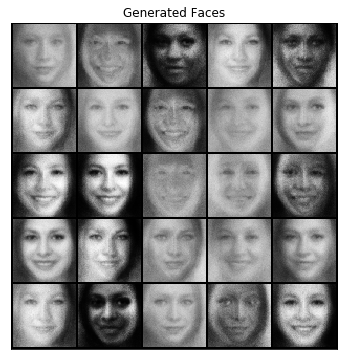

In [36]:
picture = plt.imread(images[-1])
plt.figure(figsize=(6, 6))
plt.imshow(picture)
plt.xticks([]), plt.yticks([])
plt.title('Generated Faces')
plt.show()